# Deposit rates vs US Treasury rates

**Date**: 26.05.2021  
**Author**: Robert Soczewica

The purpose of the project was to find a model that utilizes US treasury rates in order to describe the deposit rate paid. The treasury rates used in the modelling task are the CMT yields published by US Department of the Treasury on a daily basis. Provided dataset contain several yields of different maturities, starting from one month (DGS1MO) up to 30 years (DGS30). Those were intended to form the explanatory variable dataset.

The dependent variable that needed to be described by the explanatory variables was a *deposit rate paid*, which is the interest paid by the banks to their depositors. This variable was not explicitly defined, but rather some intermediary variables were provided that enabled its calculation.

## Exploratory Data Analysis (EDA)

In [1]:
import os
import numpy as np
import pandas as pd

df_depo = pd.read_excel('Deposit Interest.xlsx')
df_depo.head()

,YYYYQQ,Foreign deposits,Domestic deposits interest-bearing,Domestic deposits noninterest-bearing,Total interest expense
0,1984Q1,346927.996,1860604.628,363955.726,59109.697
1,1984Q2,345313.290,1921612.686,379300.050,62633.848
2,1984Q3,326893.665,1964712.984,364125.250,67994.237
3,1984Q4,317569.815,2043037.290,421535.819,67890.338
4,1985Q1,332165.522,2086013.731,371462.367,65997.470


In [6]:
df_depo.set_index('YYYYQQ', inplace=True)
df_depo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136 entries, 1984Q1 to 2017Q4
Data columns (total 4 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Foreign deposits                       136 non-null    float64
 1   Domestic deposits interest-bearing     136 non-null    float64
 2   Domestic deposits noninterest-bearing  136 non-null    float64
 3   Total interest expense                 136 non-null    float64
dtypes: float64(4)
memory usage: 5.3+ KB


This data is distributed on quarterly basis. As we do not have the information whether the **Foreign deposits** are interest-bearing, I used only **Domestic deposits interes-bearing** column as an interest base. Hence the interest on deposits can be calculated from the below equation:

$$ DepoRate = \frac{TotalInterestExpense}{DomesticDepositsInterestBearing} $$

I applied this in the code, as well as changed the type of date column and set it as an index.

In [8]:
depo_rate = df_depo['Total interest expense'] / df_depo['Domestic deposits interest-bearing']
depo_rate = depo_rate.to_frame().reset_index()
depo_rate.columns = ['DATE', 'DEPO']
depo_rate['DATE'] = pd.PeriodIndex(depo_rate['DATE'], freq='Q').end_time.normalize()
depo_rate.set_index('DATE', inplace=True)
depo_rate.describe()

,DEPO
count,136.000000
mean,0.014342
std,0.009126
min,0.001501
25%,0.006163
50%,0.015416
75%,0.020365
max,0.034608


Now, let's get treasury rate data.

In [12]:
df_tres = pd.DataFrame()
folder_name = 'US Treasury rates'
for f in os.listdir(folder_name):
    temp = pd.read_csv('/'.join([folder_name, f]))
    try:
        df_tres = pd.merge(df_tres, temp, how='outer', on='DATE')
    except:
        df_tres = temp

df_tres.head()

,DATE,DGS10,DGS2,DGS1,DGS5,DGS7,DGS1MO,DGS3MO,DGS30,DGS20,DGS6MO
0,1962-01-02,4.06,NaN,3.22,3.88,NaN,NaN,NaN,NaN,NaN,NaN
1,1962-01-03,4.03,NaN,3.24,3.87,NaN,NaN,NaN,NaN,NaN,NaN
2,1962-01-04,3.99,NaN,3.24,3.86,NaN,NaN,NaN,NaN,NaN,NaN
3,1962-01-05,4.02,NaN,3.26,3.89,NaN,NaN,NaN,NaN,NaN,NaN
4,1962-01-08,4.03,NaN,3.31,3.91,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_tres.tail()

,DATE,DGS10,DGS2,DGS1,DGS5,DGS7,DGS1MO,DGS3MO,DGS30,DGS20,DGS6MO
14681,2018-04-11,2.79,2.32,2.09,2.62,2.72,1.64,1.73,2.99,2.87,1.95
14682,2018-04-12,2.83,2.34,2.11,2.67,2.78,1.65,1.75,3.05,2.92,1.95
14683,2018-04-13,2.82,2.37,2.12,2.67,2.77,1.64,1.76,3.03,2.91,1.97
14684,2018-04-16,2.83,2.39,2.12,2.69,2.78,1.64,1.79,3.03,2.91,1.98
14685,2018-04-17,2.82,2.41,2.16,2.68,2.77,1.68,1.80,3.00,2.89,2.02


As it can be observed, the treasury rate data has daily frequency and wider year ranges than *depo_rate* data. It is also presented in % format instead of fractions.

In [15]:
df_tres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14686 entries, 0 to 14685
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    14686 non-null  object
 1   DGS10   14686 non-null  object
 2   DGS2    10926 non-null  object
 3   DGS1    14686 non-null  object
 4   DGS5    14686 non-null  object
 5   DGS7    12731 non-null  object
 6   DGS1MO  4361 non-null   object
 7   DGS3MO  9467 non-null   object
 8   DGS30   10741 non-null  object
 9   DGS20   6403 non-null   object
 10  DGS6MO  9467 non-null   object
dtypes: object(11)
memory usage: 1.3+ MB


In [14]:
df_tres['DGS10'].value_counts()

.        628
4.19      99
4.20      96
4.21      70
4.22      63
        ... 
9.85       1
14.09      1
1.40       1
13.05      1
13.92      1
Name: DGS10, Length: 1317, dtype: int64

We can see also that there might be many missing observations in the columns signed with '.' character, due to the fact that all the columns are of a string type. In order to move forward we need to clean the data and standarize the notation and data format. Thus I replaced all the '.' with NaN values, changed the **DATE** column to date format and rate values to float format with fraction notation.

In [16]:
df_tres['DATE'] = pd.to_datetime(df_tres['DATE'])
df_tres.set_index('DATE', inplace=True)
df_tres.replace('.', np.nan, inplace=True)
df_tres = df_tres.astype('float32') / 100
df_tres.isna().sum()

DGS10       628
DGS2       4220
DGS1        628
DGS5        628
DGS7       2498
DGS1MO    10506
DGS3MO     5611
DGS30      5392
DGS20      8546
DGS6MO     5611
dtype: int64

There are many missing observations so far, however as mentioned before, the data has daily frequency. We need to standarize the frequency among deposit rates and treasury rates. The natural way of doing it would be to resample the daily treasury rates to quarterly frequency, rather than trying to extrapolate quarterly deposit rates to a daily format. 

But at first, we may consider also transformation of both rate types to annualized percentage yields (APY), so we obtain the same units, which might be then compared using economical reasoning.

In [17]:
depo_rate = (1 + depo_rate)**4 - 1 
df_tres = (1 + df_tres/2)**2 - 1

The deposit rate comes with a quarterly frequency, so one needs to compound it by four periods to get an annualized rate. On the other hand, the CMT yields are bond equivalent yields for securities that paid interest on semiannual basis and are expressed on annualized basis. Thus to obtain an APY rate, we need to divide the rate by two and compound it through two periods as shown in the above code chunk.

After we get the same annualized rates in both group of variables, we may proceed with resampling and filtering the data, so both dataframes will have the same date index.

I decided that the treasury rates aggregated per quarter would be properly represented by the mean of daily treasury rates during that quarter.

In [18]:
# Aggregate treasury rates by quarter
df_tres = df_tres.resample('Q').mean()

# Filter data (dependent variable since '84 up to '17)
df_tres = df_tres[df_tres.index.isin(depo_rate.index)]

Next, we should divide our data into train-test samples. The train sample will be used during model selection and estimation phase, while the test sample will be used only once to assess the prediction accuracy of selected model. It is very important to not use the test set during the parameter optimization phase to avoid data leakage and look-ahead bias. 

There are many ways describing how to split the time-dependent data into train-test samples (e.g. rolling with a specified  train and evaluation windows and periodical recalibration of model parameters, KFold cross-validation with adjacent time-windows etc.), however, due to constrained time and complexity of the project, I decided to use the basic splitting with one large training set and chronogically adjacent test set. 

Such division has its pros and cons. It facilitates modelling phase, shorten the time needed for computation and its more transparent when it comes to results interpretation. On the other hand, it may fail to model long-term relationship between the variables due to high probability of sudden events during such period or changes in trends and economical regimes. 

Given the above, I decided that the test period should be significantly shorter than train period and account for around 10% of whole data set. Therefore it should be possible to choose and train the model over many economical regime changes, as well as make the final prediction on relatively short time frame. 

In [69]:
import math

test_limit = math.ceil(0.9 * len(depo_rate))
y_train, y_test = depo_rate.iloc[:test_limit], depo_rate.iloc[test_limit:]
X_train, X_test = df_tres.iloc[:test_limit], df_tres.iloc[test_limit:]

After the dataset splitting we can move forward with Exploratory Data Analysis (EDA) phase.

In [20]:
y_train.describe()

,DEPO
count,123.000000
mean,0.064628
std,0.035969
min,0.006444
25%,0.034434
50%,0.069697
75%,0.089869
max,0.145784


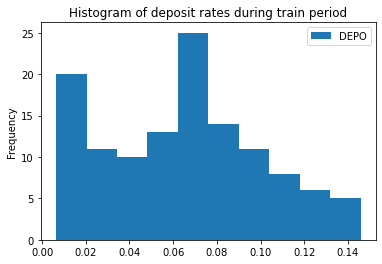

In [27]:
y_train.plot(kind='hist', title='Histogram of deposit rates during train period');

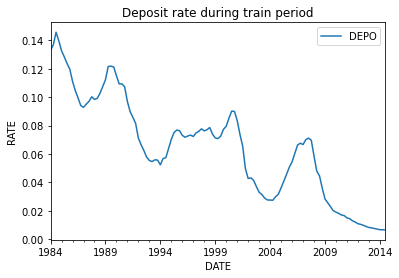

In [29]:
y_train.plot(ylabel='RATE', title="Deposit rate during train period");

As we can expect from the economical point of view, the deposit rates are decreasing in the past few decades. One should be careful in looking for seasonality as the deposit rates should be rather treated as a direct answer to economic regimes, for example responses to shocks (early '00s and '08), inflation (e.g. '80s), market competition etc.. These should be also greatly influenced by the level of interest rates (proxied by treasury yields), what I will attempt to prove afterwards.

Below are the descriptive statistics, histograms of treasury yields with different maturities and time series plots of all yields during the train period.

In [33]:
X_train.describe()

,DGS10,DGS2,DGS1,DGS5,DGS7,DGS1MO,DGS3MO,DGS30,DGS20,DGS6MO
count,123.000000,123.000000,123.000000,123.000000,123.000000,53.000000,123.000000,108.000000,84.000000,123.000000
mean,0.059498,0.047820,0.044055,0.054109,0.057220,0.014502,0.040587,0.065992,0.051872,0.042343
std,0.025803,0.030414,0.029745,0.028434,0.027300,0.016724,0.028456,0.023882,0.013993,0.029218
min,0.016480,0.002579,0.001030,0.006700,0.010828,0.000102,0.000147,0.027628,0.023790,0.000498
25%,0.041261,0.021457,0.018030,0.031715,0.036916,0.000689,0.014452,0.046748,0.043257,0.015374
50%,0.056712,0.049208,0.049337,0.055163,0.056998,0.009209,0.046363,0.063726,0.051330,0.048313
75%,0.074960,0.066303,0.062558,0.070632,0.072906,0.021435,0.058369,0.080978,0.062234,0.060928
max,0.136510,0.129045,0.121662,0.134441,0.135959,0.051730,0.110345,0.136190,0.082513,0.116017


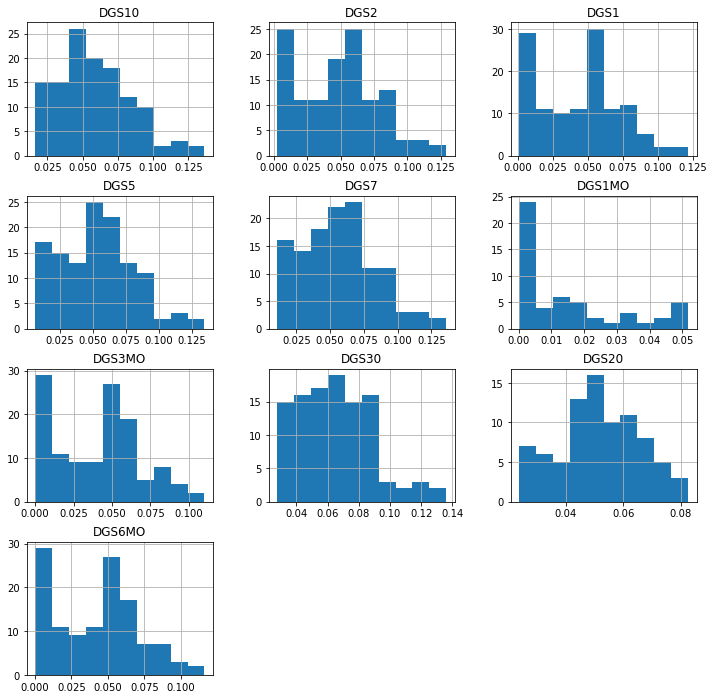

In [32]:
X_train.hist(figsize=(12, 12));

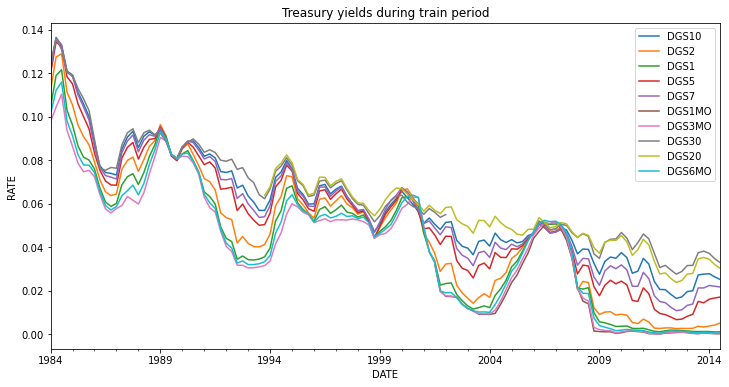

In [35]:
X_train.plot(figsize=(12, 6), ylabel='RATE', title='Treasury yields during train period');

We can observe that the plots and descriptive statistics are in line with the intuition. Over the past few decades we have experienced the declining trend in rates level. It is also visible and demanded, that the rates with longer maturities are generally expected to have higher yields.

The important thing to notice is the fact that the yields have similar shapes, which means that these should be highly positively correlated. To quantify such behavior, we may want to check the linear correlations (Pearson) among all independent variables.

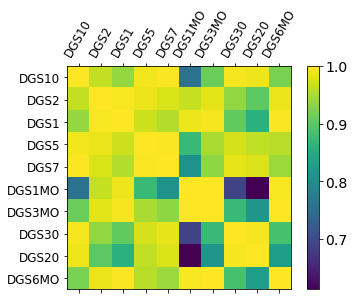

In [37]:
import matplotlib.pyplot as plt

f = plt.figure()
plt.matshow(X_train.corr(method='pearson'), fignum=f.number)
plt.xticks(range(X_train.shape[1]), X_train.columns, fontsize=12, rotation=60)
plt.yticks(range(X_train.shape[1]), X_train.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14);

As expected, the yields with similar maturities (e.g. 1MO-3MO and 20Y-30Y) are highly correlated, while the yields that have singificantly different maturities (e.g. 1MO-20Y) show lower correlation. It is an important premise, given the fact that several yields have significant amount of missing observations.

In [38]:
X_train.isna().sum()

DGS10      0
DGS2       0
DGS1       0
DGS5       0
DGS7       0
DGS1MO    70
DGS3MO     0
DGS30     15
DGS20     39
DGS6MO     0
dtype: int64

From the above correlogram we can infer that **DGS1MO** is highly correlated with **DGS3MO**, while **DGS20** and **DGS30** are highly correlated with **DGS10**. Hence, to avoid errors during modelling phase and taking into account that several variables may carry the same information (multicollinearity), I decided to remove **DGS1MO**, **DGS20** and **DGS30** from the indepednet variable set.

The time distributions of treasury rates and deposit rates also show some similarities (e.g. trend, peaks, throughs). Such behavior is demanded from the economical point of view as deposit rates should be highly influenced by the treasury rates. 

In [40]:
from scipy.stats import pearsonr, spearmanr

for col in X_train:  
    if(abs(spearmanr(X_train[col], y_train).correlation) > 0.5 and spearmanr(X_train[col], y_train).pvalue < 0.05):
        print("{0} and DEPO monotonical correlation:".format(col), spearmanr(X_train[col], y_train).correlation)

DGS10 and DEPO monotonical correlation: 0.9137248326475861
DGS2 and DEPO monotonical correlation: 0.9562433091279617
DGS1 and DEPO monotonical correlation: 0.9630147940823671
DGS5 and DEPO monotonical correlation: 0.9347486811726923
DGS7 and DEPO monotonical correlation: 0.9279900942848667
DGS3MO and DEPO monotonical correlation: 0.9721917684539088
DGS6MO and DEPO monotonical correlation: 0.9681611226477151


The results of high monotonical correlation between dependent variable and independent variables confirm above reasoning.

## Model Development

Given the fact that deposit rate and treasury yields curves have similar shapes and are highly correlated, a good way to approach such a modelling problem would be to consider at first the linear dependency. Thus my idea is to fit linear regression model, due to its simplicity, transparent assumptions and interpretability of estimated parameters. 

In [64]:
import statsmodels.api as sm

# Drop highly correlated columns with missing observations from train set
X_train = X_train.drop(columns=['DGS1MO', 'DGS30', 'DGS20']) 

# Fit linear regression model 
X_train = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train, missing='drop').fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                   DEPO   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     460.0
Date:                Wed, 26 May 2021   Prob (F-statistic):           6.07e-81
Time:                        20:03:11   Log-Likelihood:                 442.05
No. Observations:                 123   AIC:                            -868.1
Df Residuals:                     115   BIC:                            -845.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.003     -0.227      0.8

Taking into consideration above linear regression results, there are a few important things to note:

1. The Durbin-Watson test statistic for autocorrelation of residuals is near 0, which means that residuals are positively autocorrelated. This behavior violates one of the linear regression assumption (lack of autocorrelation among residuals) and could indicate that the model does not explain well the relationship between dependent and independent variables.
2. The high p-values of t-tests indicates that many explanatory variables may be statistically insignificant. However, due to the violation of autocorrelation assumption, these are not reliable.
3. High R-squared and Adj. R-squared values are also misleading and usually occur in spurious regression with highly autocorrelated residuals.
4. The p-value of Jarque-Bera test for normality is way below 0.05, which forces us to reject the null hypothesis saying that the resiudals comes from normal distribution. The test compares the central moments of a respective distribution to those coming from normal distribution. Hence we can observe that the Skew and Kurtosis of model residuals are different that the same in normal distribution (0 and 3 respectively). This also violates one of the main linear regression assumptions.

Given all the above, we may consider other model that may cope with linear regression assumptions' violation and properly model the autocorrelation term. The natural candidate is ARIMAX model, that can be treated as a combination of linear regression and ARIMA model. Thus it is considering as explanatory variables the independent variables in above defined shape, the lags of dependent variable ($AR(p)$ part) and lags of error terms ($MA(q)$ part). 

First of all, I will plot ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) to determine the appropriate number of $p$ and $q$ lags.   




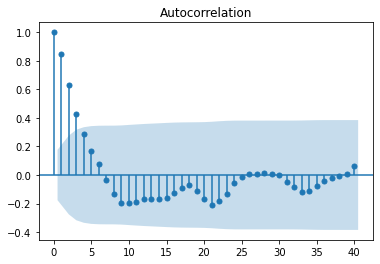

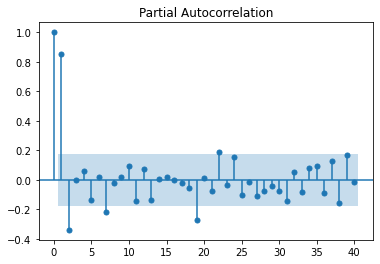

In [46]:
import statsmodels.graphics.tsaplots as tsa

tsa.plot_acf(lr.resid, alpha=0.05, lags=40)
tsa.plot_pacf(lr.resid, alpha=0.05, lags=40)
plt.show()

We can see that there is a significant autocorrelation of residuals up to 3-4 lag. Let's differentiate the series and plot the ACF and PACF again.

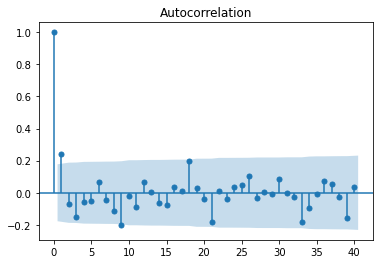

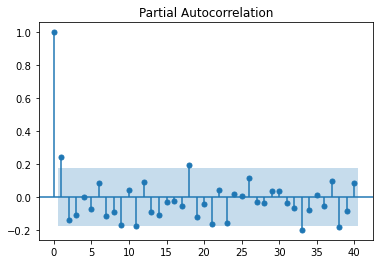

In [48]:
lr_resid_diff1 = lr.resid.diff().dropna()
tsa.plot_acf(lr_resid_diff1, alpha=0.05, lags=40)
tsa.plot_pacf(lr_resid_diff1, alpha=0.05, lags=40)
plt.show()

Now, after differencing, we ended up with one term autocorrelation. There are also some further terms that are on the border of statistical significancy (e.g 11, 18, 33, 38 lags on PACF plot). These might be related to economicall cyclicity and changes in regimes. 

Let's check what happens if we differentiate the resiudals once again. 

/Users/robertsoczewica/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


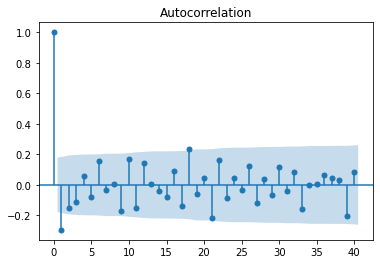

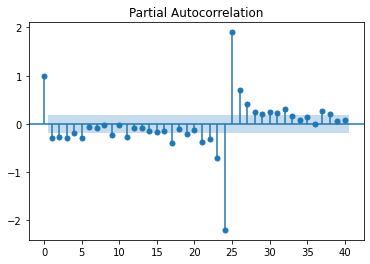

In [50]:
lr_resid_diff2 = lr_resid_diff1.diff().dropna()
tsa.plot_acf(lr_resid_diff2, alpha=0.05, lags=40)
tsa.plot_pacf(lr_resid_diff2, alpha=0.05, lags=40)
plt.show()

The negative value of first term visible on ACF plot and high discontinuities on PACF plot may indicate that we differentiate too many times. Thus it would be reasonable to stay with $d=1$ and given one relevant autocorrelation term choose $p=1$ and $q=1$ as a base model parameters. 

We should check also if there is any significant trend or seasonality among the residuals.

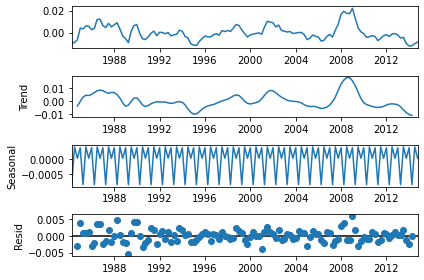

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

comps = seasonal_decompose(lr.resid)
comps.plot()
plt.show()

We can observe the sideway trend. Let's look also at the descriptive statistics of seasonal component. 

In [54]:
comps.seasonal.describe()

count    123.000000
mean      -0.000003
std        0.000523
min       -0.000861
25%       -0.000412
50%        0.000037
75%        0.000412
max        0.000425
Name: seasonal, dtype: float64

The seasonal component is 0 on average and is probably due to data frequency. Hence I decided to not model the trend (constant) and seasonality ($SARIMAX$). 

The base $ARIMAX(1, 1, 1)$ model will be defined as:

In [65]:
from statsmodels.tsa.arima.model import ARIMA

X_train.drop(columns='const', inplace=True)
arimax = ARIMA(endog=y_train, exog=X_train, order=(1,1,1)).fit()
print(arimax.summary())

                               SARIMAX Results                                
Dep. Variable:                   DEPO   No. Observations:                  123
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 559.876
Date:                Wed, 26 May 2021   AIC                          -1099.751
Time:                        20:03:34   BIC                          -1071.711
Sample:                    03-31-1984   HQIC                         -1088.362
                         - 09-30-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DGS10          0.6647      0.611      1.088      0.276      -0.532       1.862
DGS2           0.0833      0.512      0.163      0.871      -0.920       1.086
DGS1          -1.6500      0.653     -2.527      0.0

The interpretation of above results:

1. Ljung-Box test statistics is close to 0 and has p-value way above 0.05, which indicates that residuals are not autocorrelated.
2. Jarque-Bera test for normality of residuals has p-value rounded to 0, which means that we must reject the hypothesis of residuals normality. Again, it is also visible in Skew and Kurtosis, which show that the residuals are slighlty positively skewed and have fatter tails than in normal distribution.
3. The Heteroskedasticity is present in residuals, which basically mean that the variance of residuals is not constant over time.
4. Some coefficient are statistically insignificant based on z-test results. However, given the fact that normality is not met, we should approach these results carefully.
5. The Moving Average term is highly statistically insignificant.

Given the above, let's try to slightly improve the model by removing the MA term and some of the independent variables in a stepwise manner.


In [66]:
drop_names = []

while any(pval > 0.05 for pval in arimax.pvalues):
    max_pval = max(arimax.pvalues)
    var_name = arimax.pvalues[arimax.pvalues == max_pval].index[0]
    drop_names.append(var_name)
    X_train.drop(columns=var_name, inplace=True)
    arimax = ARIMA(endog=y_train, exog=X_train, order=(1,1,0)).fit()

In [67]:
print(arimax.summary())

                               SARIMAX Results                                
Dep. Variable:                   DEPO   No. Observations:                  123
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 558.881
Date:                Wed, 26 May 2021   AIC                          -1109.762
Time:                        20:03:54   BIC                          -1098.546
Sample:                    03-31-1984   HQIC                         -1105.207
                         - 09-30-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DGS1          -1.5083      0.166     -9.084      0.000      -1.834      -1.183
DGS6MO         2.1726      0.183     11.896      0.000       1.815       2.531
ar.L1          0.3922      0.094      4.170      0.0

The results show that we obtained a tight set of explanatory variables that are statistically significant. It may be close to a demanded regression form, given that many explanatory variables are highly correlated with themselves. We see that there is no autocorrelation in error terms, but also that the residuals are not normally distributed and heteroskedasticity is still present. 

Furthermore, the information criterions ($AIC$, $BIC$, $HQIC$) are significantly lower than in base $ARIMAX(1, 1, 1)$ model. It is a good sign and shows the model improvement. Of course, the presence of heteroskedasticity is worrying, but also expected, given that the economical dependencies are characterized by non-constant variance over longer periods. This phenomenon can be taken into account through variance modelling by the methodologies from $GARCH$ family. 

However, due to time constraints and in order to not complicate the modelling task too much, I will stick with estimated $ARIMAX(1, 1, 0)$ model, assume constant variance and create space for further research in this domain. 

## Prediction

Taking into consideration the above arguments, I proceed with the predictions on test set based on $ARIMAX(1, 1, 0)$ model that might be treated as a good approximation. 

In [70]:
drop_names += ['DGS1MO', 'DGS30', 'DGS20']
X_test = X_test.drop(columns=drop_names)
y_pred = arimax.get_forecast(exog=X_test, steps=len(X_test))
y_pred.summary_frame()

DEPO,mean,mean_se,mean_ci_lower,mean_ci_upper
2014-12-31,0.006322,0.002474,0.001474,0.011171
2015-03-31,0.005508,0.004240,-0.002803,0.013819
2015-06-30,0.005087,0.005710,-0.006105,0.016279
2015-09-30,0.005446,0.006957,-0.008189,0.019081
2015-12-31,0.006796,0.008041,-0.008964,0.022555
2016-03-31,0.008007,0.009005,-0.009643,0.025658
2016-06-30,0.007090,0.009880,-0.012274,0.026454
2016-09-30,0.008095,0.010684,-0.012846,0.029037
2016-12-31,0.007902,0.011433,-0.014507,0.030310
2017-03-31,0.009325,0.012136,-0.014460,0.033111


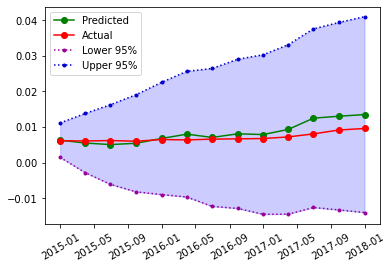

In [73]:
predicted, = plt.plot(X_test.index, y_pred.summary_frame()['mean'], 'go-', label='Predicted')

actual, = plt.plot(X_test.index, y_test, 'ro-', label='Actual')

lower, = plt.plot(X_test.index, y_pred.summary_frame()['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')

upper, = plt.plot(X_test.index, y_pred.summary_frame()['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')

plt.fill_between(X_test.index, y_pred.summary_frame()['mean_ci_lower'], y_pred.summary_frame()['mean_ci_upper'], color = 'b', alpha = 0.2)

plt.legend(handles=[predicted, actual, lower, upper])
plt.xticks(rotation=30);

In [97]:
mae = np.sum(abs(y_pred.summary_frame()['mean'].values - y_test.values)) / len(y_test)
print('Mean Abolute Error (MAE): ', mae)

Mean Abolute Error (MAE):  0.03212763935170547


The results show that the model achieves satisfactory prediction power. The $MAE$ is low and equal to 0.03. The important thing to notice is the width of confidence intervals of the prediction, which indicates a large standard error. This is expected given the simplicity of the model, the heteroskedasticity of the residuals and long prediciton horizon (more than 3 years.)

## Conclusion

In the above modelling task I was trying to show the general steps of reasoning during dynamic regression modelling. I started with data cleaning, resampling and rate compounding in order to standarize the given data. Then I performed exploratory data analysis that showed several data dependencies, the evolution of the data over time and its basic characteristics. After that I started modelling phase with simple linear regression, discussed the results and employed several steps in order to improve the model. Finally I presented the prediction of chosen $ARIMAX(1, 1, 0)$ model and discussed the results.

The presented report shows one of the approaches that may be taken in order to describe the deposit rate by the mean of treasury rates. During the project I employed several assumptions and simplified where possible. This, together with the obtained results, may be treated as a good starting point for further research and introduction of more complex modelling techniques, e.g. models from $GARCH$ family.